# Object Detection with fastai v1.x 

## Part I: Single Object Detection 

### Dataset: PASCAL VOC 

### Author: Tim Liu, URL: https://fastai.org.cn, From: Fastai Study Group @ Shanghai

using fastai v1.x rather than v0.7.x in fastai dl2 course18 (https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb) here

Let us progressively solve the multiple object detection problem just like jeremy did in 2018 dl2 course, but with latest fastai v1.x. And we will dive deeper and deeper into fastai/pytorch progressively. 

1. Step1: Build&Train a single object (largest one) classification model. 
2. Step2: Build&Train a single object's bounding box linear regression + label 
3. Step3: multi-objects bbox + labels with various approach/solutions, e.g. SSD, YOLO, Focal Loss, ...

In this repo, Step1 and Step2 are covered. I suggest write your own code rather than copy, any issues come back and checkout this notebook. Happy effective Learning!

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai import *

import json

### Prepare Data: Pascal VOC

We will be looking at the Pascal VOC dataset, http://host.robots.ox.ac.uk/pascal/VOC/. It's quite slow, so you may prefer to download from this mirror, https://pjreddie.com/projects/pascal-voc-dataset-mirror/. There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library pathlib for our paths and file access. Note that it returns an OS-specific class (on Linux, PosixPath) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like cv2) can't, in which case you can use str() to convert it to a string.

In [3]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/models'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test.json'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/tmp'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/train'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/train.json'),
 WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/valid.json')]

Here, we can read annotations from json file according to https://docs.fast.ai/data_block.html

coco = untar_data(URLs.COCO_TINY)

images, lbl_bbox = get_annotations(coco/'train.json')

...

Check https://docs.fast.ai/vision.data.html#get_annotations
it does data preprocessing for us to easily extract COCO style annotations

In [4]:
trn_images, trn_bbox = get_annotations(path/'train.json')
val_images, val_bbox = get_annotations(path/'valid.json')
images_ttl,bbox_ttl = trn_images + val_images, trn_bbox + val_bbox


In [5]:
images_ttl[1]

'000017.jpg'

In [6]:
bbox_ttl[:5]

[[[[96, 155, 270, 351]], ['car']],
 [[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']],
 [[[229, 8, 500, 245],
   [219, 229, 500, 334],
   [177, 1, 500, 90],
   [0, 1, 369, 117],
   [1, 2, 462, 243],
   [0, 224, 486, 334]],
  ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']],
 [[[124, 89, 212, 337]], ['car']],
 [[[77, 103, 183, 375],
   [87, 132, 123, 197],
   [179, 194, 229, 213],
   [188, 25, 238, 44]],
  ['aeroplane', 'aeroplane', 'person', 'person']]]

In [7]:
imgidx = 1
img = trn_images[imgidx]
img

'000017.jpg'

In [8]:
trn_images[5:10], len(trn_images)

(['000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000042.jpg'], 2501)

In [9]:
val_images[5:10], len(val_images)

(['000020.jpg', '000021.jpg', '000024.jpg', '000030.jpg', '000039.jpg'], 2510)

In [10]:
imgpath = path/'train'/img
imgpath

WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/train/000017.jpg')

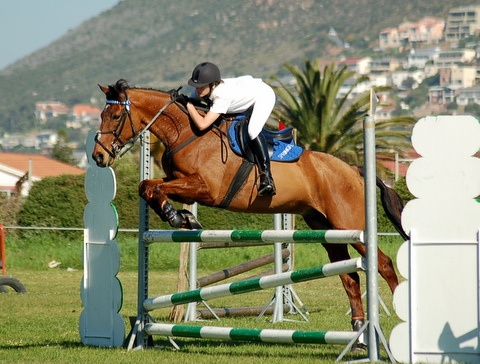

In [11]:
im = open_image(imgpath)
im

In [12]:
trn_bbox[imgidx]

[[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']]

#### Draw image with bbox

In [13]:
from PIL import ImageDraw, ImageFont
from PIL import Image
from matplotlib import patches, patheffects

In [14]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [15]:
def show_img(img, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [16]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that * in argument lists is the splat operator. In this case it's a little shortcut compared to writing out b[-2],b[-1].

In [17]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [18]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [19]:
trn_bbox[imgidx][0][0], trn_bbox[imgidx][1][0]

([61, 184, 199, 279], 'person')

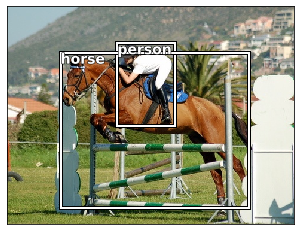

In [20]:
im = Image.open(imgpath)
ax = show_img(im)
b = bb_hw(trn_bbox[imgidx][0][0])
draw_rect(ax, b)
draw_text(ax, b[:2], trn_bbox[imgidx][1][0])

b = bb_hw(trn_bbox[imgidx][0][1])
draw_rect(ax, b)
draw_text(ax, b[:2], trn_bbox[imgidx][1][1])

In [21]:
# b = top, left, bottom, right
b

array([ 89,  77, 315, 260])

In [22]:
trn_bbox[3][1]

['car']

In [23]:
def show_img_bbox(imglist, annotations, nimg):
    imgname = imglist[nimg]
    imgpath = path/'train'/imgname
    im = Image.open(imgpath)
    ax = show_img(im)
    
    for idx in np.arange(len(annotations[nimg][0])):
        b = annotations[nimg][0][idx]
        c = annotations[nimg][1][idx]
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], c, sz=16)


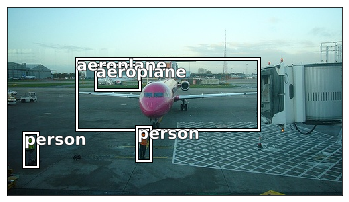

In [24]:
show_img_bbox(trn_images, trn_bbox, 4)

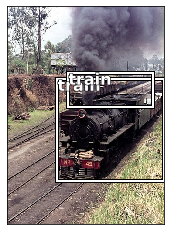

In [25]:
show_img_bbox(trn_images, trn_bbox, 6)

### Inspect raw data
Also called exploratory analysis, get_annotations make life easier

In [27]:
train_dict = json.load((path/'train.json').open())
train_dict.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [28]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
train_dict[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [30]:
train_dict[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [31]:
train_dict[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [32]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {item[ID]:item['name'] for item in train_dict[CATEGORIES]}

In [33]:
len(cats)

20

In [34]:
train_fns = {item[ID]:item[FILE_NAME] for item in train_dict[IMAGES]}
len(train_fns)

2501

In [35]:
train_ids = [item[ID] for item in train_dict[IMAGES]]

In [36]:
len(train_ids)

2501

## Largest object's [bbox, label] on one image
Find the largest object in one image, get the filename and corresponding bbox and label

A lambda function is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).f

In [26]:
array(trn_bbox[4][0][0][-2:]) - array(trn_bbox[4][0][0][:2])

array([106, 272], dtype=int64)

In [27]:
np.product(array(trn_bbox[4][0][0][-2:]) - array(trn_bbox[4][0][0][:2]))

28832

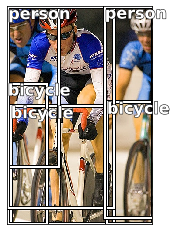

In [28]:
show_img_bbox(images_ttl, bbox_ttl, 2)

In [29]:
trn_bbox[2][0]

[[229, 8, 500, 245],
 [219, 229, 500, 334],
 [177, 1, 500, 90],
 [0, 1, 369, 117],
 [1, 2, 462, 243],
 [0, 224, 486, 334]]

In [30]:
# sometimes longer codes are more understable than one liner
def get_largest(b):
    if not b: raise Exception()
    
    top = 0
    tidx = -1
    
    for idx in np.arange(len(b)):
        lrg = np.product( array(b[idx][-2:]) - array(b[idx][:2]) )
        if(lrg > top):
            top = lrg
            tidx = idx
            
    return tidx

In [31]:
get_largest(bbox_ttl[37][0])

1

In [32]:
def get_largest_annotaion(bbox):
    lidx = get_largest(bbox[0])
    
    return [ bbox[0][lidx], bbox[1][lidx] ]

In [33]:
get_largest_annotaion(bbox_ttl[37])

[[107, 25, 396, 456], 'motorbike']

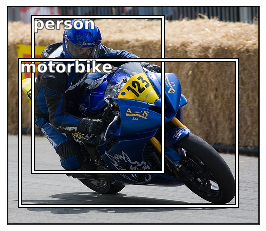

In [34]:
show_img_bbox(images_ttl, bbox_ttl, 37)

In [35]:
def show_img_bbox_lrg(imglist, annotations, nimg):
    imgname = imglist[nimg]
    imgpath = path/'train'/imgname
    im = Image.open(imgpath)
    ax = show_img(im)
    
    bbox, cat = get_largest_annotaion(annotations[nimg])
    
    b = bb_hw(bbox)
    draw_rect(ax, b)
    draw_text(ax, b[:2], cat, sz=16)


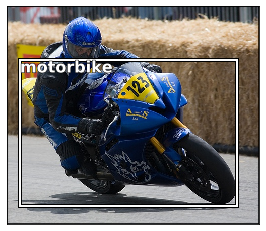

In [36]:
show_img_bbox_lrg(images_ttl, bbox_ttl, 37)

In [37]:
images_ttl[:3]

['000012.jpg', '000017.jpg', '000023.jpg']

# Step1: Largest Object Classification

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and classes.

In [38]:
# we only do multi-objects classifier for now, 
(path/'tmp').mkdir(exist_ok=True)
CSV = path/'tmp/largest_labels.csv'

In [39]:
len(images_ttl), len(bbox_ttl)

(5011, 5011)

In [40]:
bbox_ttl[3][1][0]

'car'

In [41]:
# get classes of largest bbox total
def get_bbox_ttl_lrg_c(bbox_ttl):
    ret = []
    for idx in np.arange(len(bbox_ttl)):
        ret.append(get_largest_annotaion(bbox_ttl[idx])[1])
    return ret        

In [42]:
bbox_ttl_lrg_c = get_bbox_ttl_lrg_c(bbox_ttl)
len(bbox_ttl_lrg_c)

5011

In [39]:
bbox_ttl_lrg_c[:2]

['car', 'horse']

In [40]:
df = pd.DataFrame({'fnames':images_ttl, 'labels':bbox_ttl_lrg_c}, columns=['fnames', 'labels'])
df.head()

fnames     labels
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [54]:
df.to_csv(CSV, index=False)

### Create Databunch and Learner

In [37]:
tfms = get_transforms(flip_vert=False, max_rotate=20, p_affine =1., p_lighting=1.,
                      max_zoom=1.2, max_warp=0.1)

In [56]:
bs=16
sz=224

In [59]:
src = (ImageList.from_csv(path, 'tmp/largest_labels.csv', folder='train') #Where to find the data? -> in path and its subfolders
#        .split_by_files(valid_names=val_images)             
        .split_by_rand_pct()
        .label_from_df()
        #How to find the labels? -> use get_y_func on the file name of the data
        .add_test_folder())              #Optionally add a test set (here default name is test)
src

LabelLists;

Train: LabelList (4009 items)
x: ImageList
Image (3, 333, 500),Image (3, 364, 480),Image (3, 500, 334),Image (3, 333, 500),Image (3, 281, 500)
y: CategoryList
car,horse,person,car,aeroplane
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: CategoryList
person,sheep,bird,cat,diningtable
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Test: LabelList (4952 items)
x: ImageList
Image (3, 500, 353),Image (3, 500, 335),Image (3, 375, 500),Image (3, 406, 500),Image (3, 375, 500)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\pascal_2007

In [60]:
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

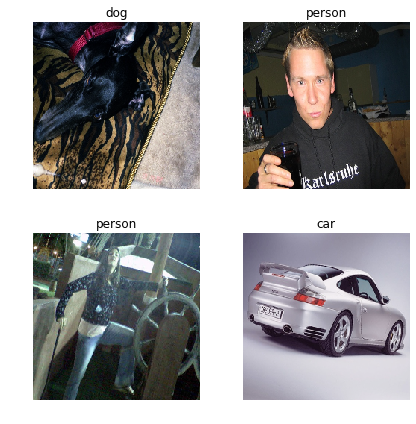

In [61]:
data.show_batch(rows=2, figsize=(6,6))

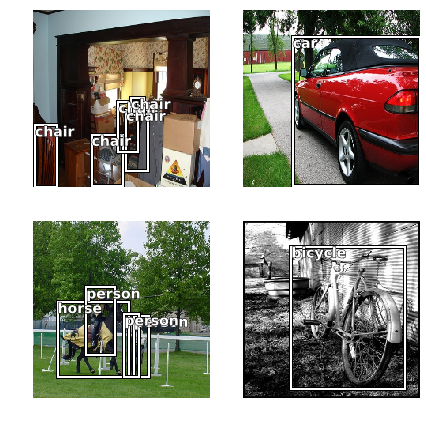

In [57]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

In [63]:
data.train_ds.classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

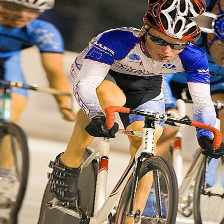

In [62]:
data.train_ds[2][0]

### Model Def & Train

The rest is just as easy as mnist

In [72]:
arch = models.resnet34

In [73]:
learn = cnn_learner(data, arch, metrics=accuracy)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,aeroplane,aeroplane
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
horse,cat,car,bottle,cat
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Test: LabelList (4952 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\pascal_2007, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


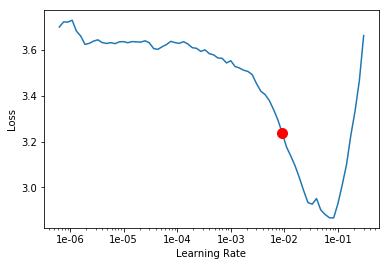

In [67]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [74]:
lr = 1e-2
learn.fit_one_cycle(1, lr, wd=0.2)

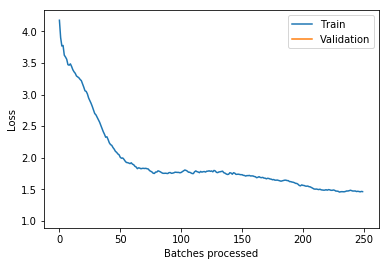

In [108]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


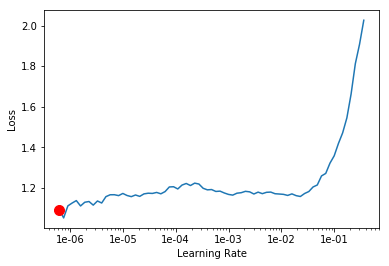

In [109]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [75]:
learn.freeze()

In [76]:
learn.fit_one_cycle(1, lr/5, wd=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05


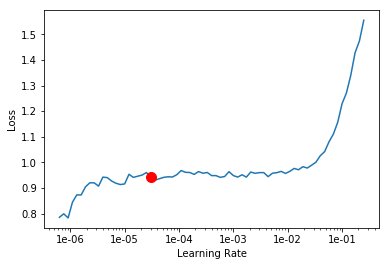

In [86]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [90]:
gc.collect()

11

In [88]:
learn.unfreeze()
learn.fit_one_cycle(3, 3e-5, wd=0.2)

In [89]:
learn.save('step_one')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


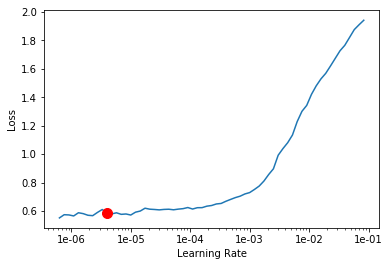

In [91]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [92]:
learn.freeze()
learn.fit_one_cycle(1, 4e-6, wd=0.2)

In [99]:
learn.load('step_one')

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,aeroplane,aeroplane
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
horse,cat,car,bottle,cat
Path: C:\Users\Tim\.fastai\data\pascal_2007;

Test: LabelList (4952 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\pascal_2007, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1

### Predict on Test dataset

In [100]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [101]:
learn.data.test_ds.items[:5]

array([WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test/000001.jpg'),
       WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test/000002.jpg'),
       WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test/000003.jpg'),
       WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test/000004.jpg'),
       WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/test/000006.jpg')], dtype=object)

In [303]:
preds[:3]

NameError: name 'preds' is not defined

In [103]:
classes = data.train_ds.classes
results = ["" for x in range(preds.shape[0])]

In [115]:
for i in np.arange(preds.shape[0]):
    results[i] = np.argmax(preds[i]).numpy()

results[:3]

[array(14, dtype=int64),
 array(18, dtype=int64),
 array(15, dtype=int64),
 array(6, dtype=int64),
 array(17, dtype=int64),
 array(17, dtype=int64),
 array(12, dtype=int64),
 array(11, dtype=int64),
 array(9, dtype=int64)]

Replace Test dataset's EmptyLabelList by predicted results

In [116]:
test_cats = CategoryList(results, classes)
test_cats

CategoryList (4952 items)
person,train,pottedplant,car,sofa
Path: .

In [117]:
data.test_ds.y = test_cats

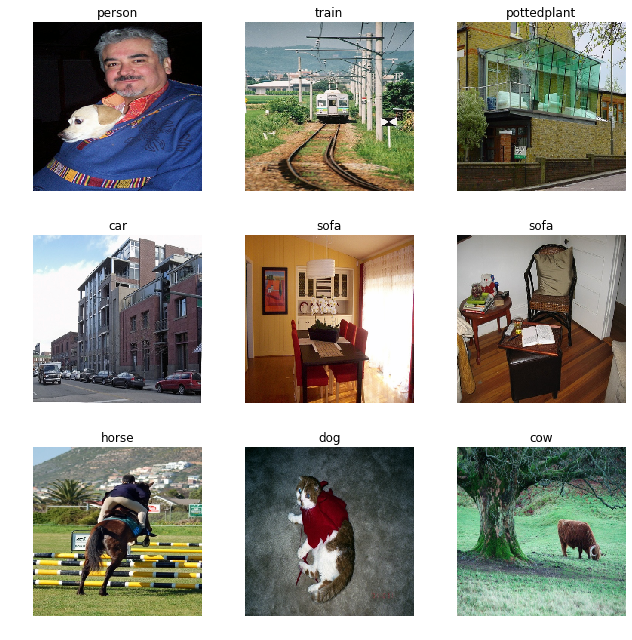

In [118]:
data.show_batch(rows=3, ds_type=DatasetType.Test, figsize=(9,9))

# Step2-1: BBox Only with FloatList
Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

#### Get familiar with ImageBBox 
Each BBox contains one 2D Tensor (N*4: Number of objects * [top_left, bottom_right] bounding box points pair), and one array of MultiCategoryList
https://docs.fast.ai/vision.image.html#ImageBBox

Create an ImageBBox object from a flow of coordinates. Those coordinates are expected to be in a FlowField with an underlying flow of size 4N, if we have N bboxes, describing for each box the top left, top right, bottom left, bottom right corners. Coordinates need to be scaled to the range (-1,1) which will be done in the intialization if scale is left as True. Convention is to have point coordinates in the form [y,x] unless y_first is set to False. labels is an optional collection of labels, which should be the same size as flow. pad_idx is used if the set of transform somehow leaves the image without any bounding boxes.

### show image with its largest bbox with fastai ImageBBox
sample code:

- img = open_image('imgs/car_bbox.jpg')
- bbox = ImageBBox.create(*img.size, [[96, 155, 270, 351]], labels=[0], classes=['car'])
- img.show(y=bbox)

In [43]:
# show image with largest bbox by ImageBBox
def show_imagebbox_lrg(imglist, annotations, nimg):
    imgname = imglist[nimg]
    imgpath = path/'train'/imgname
    imgbb = open_image(imgpath)
    
    b, cat = get_largest_annotaion(annotations[nimg])
    bbox = ImageBBox.create(*imgbb.size, [b], labels=[0], classes=[cat])
    imgbb.show(y=bbox)

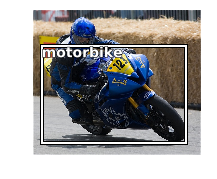

In [44]:
show_imagebbox_lrg(images_ttl, bbox_ttl, 37)

When we do data augmentation, we want to keep the target object within the bbox, fastai takes care of this with tfm_y=True parameter in transform

In [45]:
def get_largest_annotaion_array(bbox):
    lidx = get_largest(bbox[0])
    
    return [ [ np.float32( bbox[0][lidx] ) ], [bbox[1][lidx]] ]

In [46]:
# get largest bounding boxes of total images
def get_bbox_ttl_lrg_b(bbox_ttl):
    ret = []
    for idx in np.arange(len(bbox_ttl)):
        ret.append(get_largest_annotaion_array(bbox_ttl[idx])[0])
    return ret

In [47]:
bbox_ttl_lrg_b = get_bbox_ttl_lrg_b(bbox_ttl)
bbox_ttl_lrg_b[:2]

[[array([ 96., 155., 270., 351.], dtype=float32)],
 [array([ 77.,  89., 336., 403.], dtype=float32)]]

In [48]:
img2bbox_lrg = dict(zip(images_ttl,bbox_ttl_lrg_b))
get_y_func_step2 = lambda o: img2bbox_lrg[o.name]

In [49]:
img2bbox_lrg

{'000012.jpg': [array([ 96., 155., 270., 351.], dtype=float32)],
 '000017.jpg': [array([ 77.,  89., 336., 403.], dtype=float32)],
 '000023.jpg': [array([  1.,   2., 462., 243.], dtype=float32)],
 '000026.jpg': [array([124.,  89., 212., 337.], dtype=float32)],
 '000032.jpg': [array([ 77., 103., 183., 375.], dtype=float32)],
 '000033.jpg': [array([106.,   8., 263., 499.], dtype=float32)],
 '000034.jpg': [array([166., 115., 400., 360.], dtype=float32)],
 '000035.jpg': [array([ 97., 217., 318., 465.], dtype=float32)],
 '000036.jpg': [array([ 78.,  26., 344., 319.], dtype=float32)],
 '000042.jpg': [array([ 31., 262., 295., 500.], dtype=float32)],
 '000044.jpg': [array([  0.,   0., 330., 370.], dtype=float32)],
 '000047.jpg': [array([  0.,  14., 312., 459.], dtype=float32)],
 '000048.jpg': [array([  0.,   1., 500., 302.], dtype=float32)],
 '000061.jpg': [array([ 10., 273., 279., 437.], dtype=float32)],
 '000064.jpg': [array([ 22.,   0., 500., 451.], dtype=float32)],
 '000066.jpg': [array([18

### export largest bbox into csv

In [50]:
BB_CSV = path/'tmp/bb.csv'

In [51]:
bbls = [' '.join(str(p) for p in o[0]) for o in bbox_ttl_lrg_b]
bbls[:3]

['96.0 155.0 270.0 351.0', '77.0 89.0 336.0 403.0', '1.0 2.0 462.0 243.0']

In [52]:
df = pd.DataFrame({'fnames':images_ttl, 'bbox_lrg':bbls}, columns=['fnames', 'bbox_lrg'])
df.head()

fnames                bbox_lrg
0  000012.jpg  96.0 155.0 270.0 351.0
1  000017.jpg   77.0 89.0 336.0 403.0
2  000023.jpg     1.0 2.0 462.0 243.0
3  000026.jpg  124.0 89.0 212.0 337.0
4  000032.jpg  77.0 103.0 183.0 375.0

In [88]:
df.to_csv(BB_CSV, index=False)

### Show image bbox together with its ImagePoints (top_left, bottom_right)

Add  FloatList as labels for train and valid dataset won't help us perform this bbox regression task, since fastai data_block tends to generate huge classes of all FloatItems 

Try to use PointsItemList and ImagePoints, the doc and tutorial are good enough
https://docs.fast.ai/vision.image.html#ImagePoints

Create another notebook and follow the regression tutorial
https://docs.fast.ai/tutorial.inference.html#A-regression-example

In [53]:
def draw_pts(ax, b):
    patch = ax.add_patch(patches.Circle(b[:2], fill=True, edgecolor='red', lw=2))
    patch = ax.add_patch(patches.Circle(b[:2]+b[-2:], fill=True, edgecolor='red', lw=2))
    #draw_outline(patch, 4)

In [54]:
def show_image_bbpts_lrg(imglist, annotations, nimg):
    imgname = imglist[nimg]
    print(imgname)
    imgpath = path/'train'/imgname
    im = Image.open(imgpath)
    ax = show_img(im)
     
    bbox, cat = get_largest_annotaion(annotations[nimg])
    
    b = bb_hw(bbox)
    draw_rect(ax, b)
    draw_text(ax, b[:2], cat, sz=16)
    draw_pts(ax,b)
    
    # draw corner points


000163.jpg


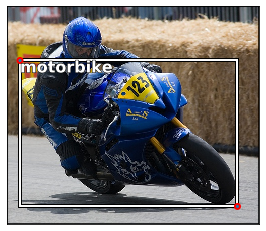

In [55]:
show_image_bbpts_lrg(images_ttl, bbox_ttl,37)

In [56]:
FloatTensor([bbox_ttl[37][0][0][:2], bbox_ttl[37][0][0][-2:]])

tensor([[ 21.,  51.],
        [328., 308.]])

In [57]:
def show_imagepoints_lrg(imglist, annotations, nimg):
    imgname = imglist[nimg]
    imgpath = path/'train'/imgname
    pimg = open_image(imgpath)
    
    bbox, cat = get_largest_annotaion(annotations[nimg])
    pts = FloatTensor([bbox[:2],bbox[-2:]])
    imgpts = ImagePoints(FlowField(pimg.size, pts))
    pimg.show(y=imgpts)
    
    imgbb = ImageBBox.create(*pimg.size, [bbox], labels=[0], classes=[cat])
    pimg.show(y=imgbb)

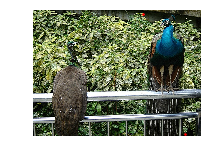

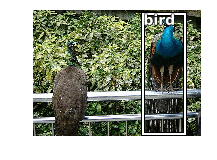

In [58]:
show_imagepoints_lrg(images_ttl, bbox_ttl,67)

In [59]:
# because we can only open_image to get image size, it's slow
# another way is to use label_from_df and load labels from csv file
def get_y_func_bb(o):
#    imgpath = path/'train'/o.name
#    pimg = open_image(imgpath)
        
    bbox = img2bbox_lrg[o.name]
    #print(bbox)
    pts = FloatTensor([bbox[0][:2], bbox[0][-2:]])
    # try one top_left point here to avoid dump
    # pts = FloatTensor([bbox[0][:2]])
    #pts.reshape(-1)
    #imgpts = ImagePoints(FlowField(pimg.size, pts))
    #assert(pts.shape == torch.Size([2, 2]))
    
    return pts

In [60]:
# get largest bounding boxes of total images
def get_imgpts_ttl_lrg():
    ret = []
    for idx in np.arange(len(bbox_ttl_lrg_b)):
        #pts = FloatTensor([bbox_ttl_lrg_b[idx][0][:2],bbox_ttl_lrg_b[idx][0][-2:]])
        pts = bbox_ttl_lrg_b[idx][0].astype(np.float32)
        ret.append(pts)
    return ret

In [61]:
imgpts_ttl_lrg = get_imgpts_ttl_lrg()
imgpts_ttl_lrg

[array([ 96., 155., 270., 351.], dtype=float32),
 array([ 77.,  89., 336., 403.], dtype=float32),
 array([  1.,   2., 462., 243.], dtype=float32),
 array([124.,  89., 212., 337.], dtype=float32),
 array([ 77., 103., 183., 375.], dtype=float32),
 array([106.,   8., 263., 499.], dtype=float32),
 array([166., 115., 400., 360.], dtype=float32),
 array([ 97., 217., 318., 465.], dtype=float32),
 array([ 78.,  26., 344., 319.], dtype=float32),
 array([ 31., 262., 295., 500.], dtype=float32),
 array([  0.,   0., 330., 370.], dtype=float32),
 array([  0.,  14., 312., 459.], dtype=float32),
 array([  0.,   1., 500., 302.], dtype=float32),
 array([ 10., 273., 279., 437.], dtype=float32),
 array([ 22.,   0., 500., 451.], dtype=float32),
 array([181., 241., 259., 274.], dtype=float32),
 array([142., 120., 460., 375.], dtype=float32),
 array([  0.,   1., 333., 306.], dtype=float32),
 array([ 74.,  14., 412., 475.], dtype=float32),
 array([ 32., 108., 309., 447.], dtype=float32),
 array([ 50.,  21., 

In [62]:
img2pts_lrg = dict(zip(images_ttl,imgpts_ttl_lrg))
get_y_func_bb_lrg = lambda o: (img2pts_lrg[o.name])

In [63]:
img2pts_lrg

{'000012.jpg': array([ 96., 155., 270., 351.], dtype=float32),
 '000017.jpg': array([ 77.,  89., 336., 403.], dtype=float32),
 '000023.jpg': array([  1.,   2., 462., 243.], dtype=float32),
 '000026.jpg': array([124.,  89., 212., 337.], dtype=float32),
 '000032.jpg': array([ 77., 103., 183., 375.], dtype=float32),
 '000033.jpg': array([106.,   8., 263., 499.], dtype=float32),
 '000034.jpg': array([166., 115., 400., 360.], dtype=float32),
 '000035.jpg': array([ 97., 217., 318., 465.], dtype=float32),
 '000036.jpg': array([ 78.,  26., 344., 319.], dtype=float32),
 '000042.jpg': array([ 31., 262., 295., 500.], dtype=float32),
 '000044.jpg': array([  0.,   0., 330., 370.], dtype=float32),
 '000047.jpg': array([  0.,  14., 312., 459.], dtype=float32),
 '000048.jpg': array([  0.,   1., 500., 302.], dtype=float32),
 '000061.jpg': array([ 10., 273., 279., 437.], dtype=float32),
 '000064.jpg': array([ 22.,   0., 500., 451.], dtype=float32),
 '000066.jpg': array([181., 241., 259., 274.], dtype=fl

In [64]:
imgpath = path/'train/000005.jpg'
imgp = get_y_func_bb_lrg(imgpath)
imgp

array([263., 164., 372., 253.], dtype=float32)

In [65]:
imgp.reshape(-1)

array([263., 164., 372., 253.], dtype=float32)

### build databunch from imagepoints
- [TODO]Report and ask. ImagePoints does NOT work properly , similar code as https://docs.fast.ai/tutorial.data.html#A-regression-example

databunch tells me the ImagePoints are of different shapes (e.g. [torch.Size(2,2), torch.Size(1,2)] ), but lambda get_y_func_bb return all the same shapes, all torch.Size(2,2) .

### build the continuous regression databunch and Model 

Labels shall be custom item list as FloatList

reference:
- https://docs.fast.ai/data_block.html#FloatList
- https://medium.com/@btahir/a-quick-guide-to-using-regression-with-image-data-in-fastai-117304c0af90

FloatList can have multiple dimensions

reference

<code>class FloatList(ItemList):
    "`ItemList` suitable for storing the floats in items for regression. Will add a `log` if this flag is `True`."
    def __init__(self, items:Iterator, log:bool=False, classes:Collection=None, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        self.log = log
        self.copy_new.append('log')
        self.c = self.items.shape[1] if len(self.items.shape) > 1 else 1
        self.loss_func = MSELossFlat()</code>

In [66]:
timgpts_ttl_lrg = Tensor(np.array(imgpts_ttl_lrg, dtype=np.float32))
timgpts_ttl_lrg, len(timgpts_ttl_lrg)

(tensor([[ 96., 155., 270., 351.],
         [ 77.,  89., 336., 403.],
         [  1.,   2., 462., 243.],
         ...,
         [125., 191., 275., 403.],
         [212.,  88., 301., 432.],
         [120.,  76., 316., 178.]]), 5011)

Different with Step1, we use get_y_func for labels, each image is labelled with 2 ImagePoints (top_left, bottom_right)

In [67]:
imgsrc = (ImageList
            .from_folder(path/'train')    
            .split_by_rand_pct(seed=42)
            .label_from_func(get_y_func_bb_lrg, label_cls=FloatList)
            .add_test_folder() 
            )
imgsrc

LabelLists;

Train: LabelList (4009 items)
x: ImageList
Image (3, 375, 500),Image (3, 333, 500),Image (3, 375, 500),Image (3, 333, 500),Image (3, 500, 334)
y: FloatList
[263. 164. 372. 253.],[ 49. 140. 330. 500.],[171.  68. 330. 270.],[ 96. 155. 270. 351.],[ 71.  91. 473. 305.]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 375, 500),Image (3, 323, 500),Image (3, 333, 500),Image (3, 375, 500),Image (3, 375, 500)
y: FloatList
[ 70.  75. 305. 491.],[193.  93. 323. 500.],[125.  74. 250. 436.],[ 56.  61. 322. 406.],[ 59. 142. 375. 364.]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: C:\Users\Tim\.fastai\data\pascal_2007\train

In [170]:
np.float32(imgsrc.valid.x[0].size), len(imgsrc.valid.x)

(array([375., 500.], dtype=float32), 1002)

In [68]:
# this func is a little slow, 
def get_imgsizes(imgs):
    ret = np.zeros((len(imgs), 4))
    
    for i in np.arange(len(imgs)):
        ret[i] = [imgs[i].size[0], imgs[i].size[1], imgs[i].size[0], imgs[i].size[1]]

    return np.float32(ret)

In [69]:
trn_szs = get_imgsizes(imgsrc.train.x)
trn_szs

array([[375., 500., 375., 500.],
       [333., 500., 333., 500.],
       [375., 500., 375., 500.],
       [333., 500., 333., 500.],
       ...,
       [332., 500., 332., 500.],
       [333., 500., 333., 500.],
       [375., 500., 375., 500.],
       [374., 500., 374., 500.]], dtype=float32)

In [70]:
vld_szs = get_imgsizes(imgsrc.valid.x)
vld_szs

array([[375., 500., 375., 500.],
       [323., 500., 323., 500.],
       [333., 500., 333., 500.],
       [375., 500., 375., 500.],
       ...,
       [375., 500., 375., 500.],
       [500., 333., 500., 333.],
       [429., 500., 429., 500.],
       [500., 348., 500., 348.]], dtype=float32)

In [69]:
maxv = np.float32(timgpts_ttl_lrg.reshape(-1)[np.argmax(timgpts_ttl_lrg.reshape(-1))])
maxv

500.0

In [70]:
# bbox relative position to image's (height, width)
def norm_simple(bbs, szs):
    return bbs / szs

In [71]:
def denorm_simple(bbsn, szs):
    return np.array(bbsn) * szs

In [72]:
norm_simple(imgsrc.train.y.items, trn_szs)

array([[0.701333, 0.328   , 0.992   , 0.506   ],
       [0.147147, 0.28    , 0.990991, 1.      ],
       [0.456   , 0.136   , 0.88    , 0.54    ],
       [0.288288, 0.31    , 0.810811, 0.702   ],
       ...,
       [0.003012, 0.      , 1.      , 1.      ],
       [0.36036 , 0.152   , 0.948949, 0.356   ],
       [0.376   , 0.382   , 0.498667, 0.66    ],
       [0.008021, 0.136   , 0.92246 , 0.784   ]], dtype=float32)

In [73]:
# very simple&silly normalization, just divide max number
# but also easy to denorm
train_y_norm = norm_simple(imgsrc.train.y.items, trn_szs)
imgsrc.train.y.items = train_y_norm

In [74]:
denorm_simple(train_y_norm, trn_szs)

array([[263.     , 164.     , 372.     , 252.99998],
       [ 49.     , 140.     , 330.     , 500.     ],
       [171.     ,  68.     , 330.     , 270.     ],
       [ 96.     , 155.     , 270.     , 351.     ],
       ...,
       [  1.     ,   0.     , 332.     , 500.     ],
       [120.     ,  76.     , 316.     , 178.     ],
       [141.     , 191.     , 187.     , 330.     ],
       [  3.     ,  68.     , 345.     , 392.     ]], dtype=float32)

In [200]:
valid_y_norm = norm_simple(imgsrc.valid.y.items, vld_szs)
imgsrc.valid.y.items = valid_y_norm

In [201]:
imgsrc.train.y.items

array([[0.701333, 0.328   , 0.992   , 0.506   ],
       [0.147147, 0.28    , 0.990991, 1.      ],
       [0.456   , 0.136   , 0.88    , 0.54    ],
       [0.288288, 0.31    , 0.810811, 0.702   ],
       ...,
       [0.003012, 0.      , 1.      , 1.      ],
       [0.36036 , 0.152   , 0.948949, 0.356   ],
       [0.376   , 0.382   , 0.498667, 0.66    ],
       [0.008021, 0.136   , 0.92246 , 0.784   ]], dtype=float32)

In [202]:
imgsrc.valid.y.items

array([[0.186667, 0.15    , 0.813333, 0.982   ],
       [0.597523, 0.186   , 1.      , 1.      ],
       [0.375375, 0.148   , 0.750751, 0.872   ],
       [0.149333, 0.122   , 0.858667, 0.812   ],
       ...,
       [0.101333, 0.084   , 0.898667, 0.974   ],
       [0.438   , 0.384384, 0.95    , 0.960961],
       [0.006993, 0.542   , 0.988345, 0.994   ],
       [0.056   , 0.002874, 1.      , 0.560345]], dtype=float32)

In [203]:
bs=32
sz=224

In [327]:
# Notcie: don't transform y here, since FloatItem's apply_tfms is not implemented

data2 = (imgsrc
        .transform(get_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.,p_affine=1.,p_lighting=0.2),
#        .transform(get_transforms(),         
                   size=(sz,sz) #, tfm_y=True
                  )
        .databunch(bs=bs)
        .normalize(imagenet_stats)
       )

#### when use FloatList with tfm_y=True, Exception: It's not possible to apply those transforms to your dataset:
Not implemented: you can't apply transforms to this type of item (FloatItem)

Pitty, so no rotate, no warp, no zoom, no tfm_y
Not enough time to extend FloatItem with apply_tfms. Later in step2-2, move on to ImageBBox (ImageBBox can be transformed), here we keep things simple and intuitive

In [205]:
data2

ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.701333 0.328    0.992    0.506   ],[0.147147 0.28     0.990991 1.      ],[0.456 0.136 0.88  0.54 ],[0.288288 0.31     0.810811 0.702   ],[0.142    0.272455 0.946    0.913174]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.186667 0.15     0.813333 0.982   ],[0.597523 0.186    1.       1.      ],[0.375375 0.148    0.750751 0.872   ],[0.149333 0.122    0.858667 0.812   ],[0.157333 0.284    1.       0.728   ]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: C:\Users\Tim\.fastai\data\pascal_2007\train

In [206]:
data2.train_ds.x.items[0]

WindowsPath('C:/Users/Tim/.fastai/data/pascal_2007/train/000005.jpg')

In [207]:
data2.train_ds.y.items[:2]

array([[0.701333, 0.328   , 0.992   , 0.506   ],
       [0.147147, 0.28    , 0.990991, 1.      ]], dtype=float32)

In [208]:
data2.valid_ds.y.items[:2]

array([[0.186667, 0.15    , 0.813333, 0.982   ],
       [0.597523, 0.186   , 1.      , 1.      ]], dtype=float32)

#### Got an error here
UserWarning: It's not possible to collate samples of your dataset together in a batch. 
https://github.com/fastai/fastai/issues/1602

##### Got an error here
d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
  
- converted bbox to int64 will solve it

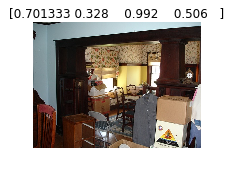

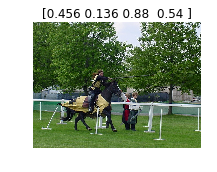

In [209]:
data2.train_ds.x[0].show(y=data2.train_ds.y[0])
data2.train_ds.x[2].show(y=data2.train_ds.y[2])

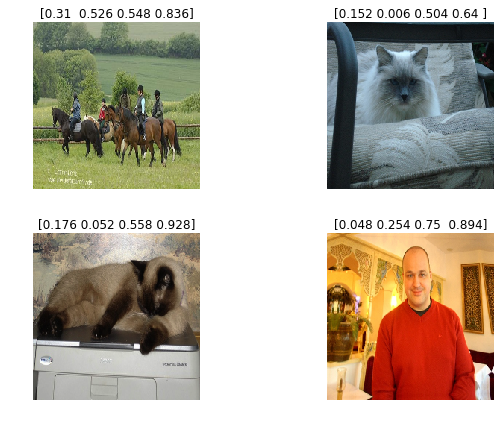

In [288]:
data2.show_batch(rows=2, figsize=(9,6))

###  Model for single bbox and Train

the model's output layer last out_features=4, because we have 4 floats to represent the bbox

In [379]:
arch = models.resnet18

#learn = Learner(data2,arch(),loss_func=nn.L1Loss())
learn2 = cnn_learner(data2, arch, loss_func=nn.L1Loss())
learn2.to_fp16()

NameError: name 'data2' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


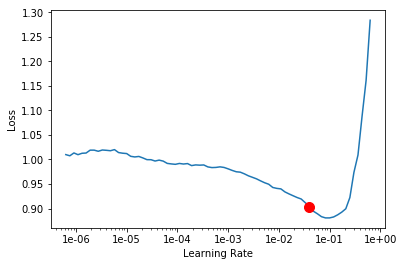

In [262]:
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [263]:
lr = 4e-2
learn2.fit_one_cycle(5, lr)

In [264]:
learn2.save('step2-1')

In [121]:
learn2.load('step2-1').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.526 0.328 0.744 0.506],[0.098 0.28  0.66  1.   ],[0.342 0.136 0.66  0.54 ],[0.192 0.31  0.54  0.702],[0.142 0.182 0.946 0.61 ]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.14  0.15  0.61  0.982],[0.386 0.186 0.646 1.   ],[0.25  0.148 0.5   0.872],[0.112 0.122 0.644 0.812],[0.118 0.284 0.75  0.728]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: C:\Users\Tim\.fastai\data\pascal_2007\train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [276]:
gc.collect()

1930

In [265]:
learn2.freeze()
learn2.fit_one_cycle(7, 1e-2)

In [266]:
learn2.save('step2-1-2')

In [277]:
learn2.load('step2-1-2').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.701333 0.328    0.992    0.506   ],[0.147147 0.28     0.990991 1.      ],[0.456 0.136 0.88  0.54 ],[0.288288 0.31     0.810811 0.702   ],[0.142    0.272455 0.946    0.913174]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0.186667 0.15     0.813333 0.982   ],[0.597523 0.186    1.       1.      ],[0.375375 0.148    0.750751 0.872   ],[0.149333 0.122    0.858667 0.812   ],[0.157333 0.284    1.       0.728   ]
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: C:\Users\Tim\.fastai\data\pascal_2007\train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


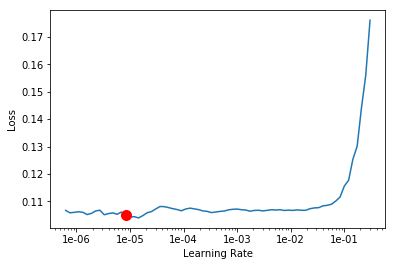

In [268]:
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [278]:
learn2.freeze()
learn2.fit_one_cycle(5, 5e-3)

In [279]:
learn2.save('step2-1-3')

#if out of memory, run following codes would not require kernel restart 
<code>
data2 = None
learn2.data = None
gc.collect()
</code>

#### Check Predicted BBox 
plot learned bbox by 'denormalize' the predicted result

In [280]:
preds2, _ = learn2.get_preds(ds_type=DatasetType.Valid)

In [281]:
denorm_simple(learn2.data.valid_ds.y.items[:5], vld_szs[:5])

array([[ 70.      ,  75.      , 305.      , 491.      ],
       [193.      ,  93.      , 323.      , 500.      ],
       [125.00001 ,  74.      , 250.00002 , 436.      ],
       [ 55.999996,  61.      , 322.      , 406.      ],
       [ 59.      , 142.      , 375.      , 364.      ]], dtype=float32)

In [282]:
denorm_simple(np.array(preds2[:5]), vld_szs[:5])

array([[ 54.473877,  15.052795, 372.0703  , 466.55273 ],
       [141.15479 ,  74.76807 , 276.63184 , 447.26562 ],
       [120.48486 , 124.63379 , 246.98584 , 427.00195 ],
       [111.23657 ,  72.81494 , 337.64648 , 305.66406 ],
       [ 54.519653, 140.86914 , 369.68994 , 355.95703 ]], dtype=float32)

#### get bbox from img2pts_lrg, which is dictionary of (fname, bbox)

In [71]:
def show_imgbbox_fname(fn, bb, pbb):
    print(fn)
    imgpath = path/'train'/fn
    img = Image.open(imgpath)
    ax = show_img(img)

    # draw ground truth bbox
    b = bb_hw(bb)
    draw_rect(ax, b)
    
    # draw predicted bbox with red points
    pb = bb_hw(pbb)
    draw_pts(ax,pb)
    

In [72]:
def show_imgbbox_idx(idx):
    fn = learn2.data.valid_ds.x.items[idx].name
    bbox = denorm_simple(learn2.data.valid_ds.y.items[idx], vld_szs[idx])
    pbbox = denorm_simple(preds2[idx], vld_szs[idx])
    show_imgbbox_fname(fn, bbox, pbbox)

In [73]:
# show many images with their largest bbox (truth, predicted) together, starting from first image
def show_imgbbox_list(ds, preds, szs, first, row, col):
    fig, axes = plt.subplots(row, col, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        idx = first + i
        fn = ds.x.items[idx].name
        imgpath = path/'train'/fn
        img = Image.open(imgpath)   
        ax = show_img(img, ax=ax)
        
        # draw ground truth bbox
        bbox = denorm_simple(ds.y.items[idx], szs[idx])
        b = bb_hw(bbox)
        draw_rect(ax, b)

        # draw predicted bbox with red points
        pbbox = denorm_simple(preds[idx], szs[idx])
        pb = bb_hw(pbbox)
        draw_pts(ax,pb)
        
    plt.tight_layout()


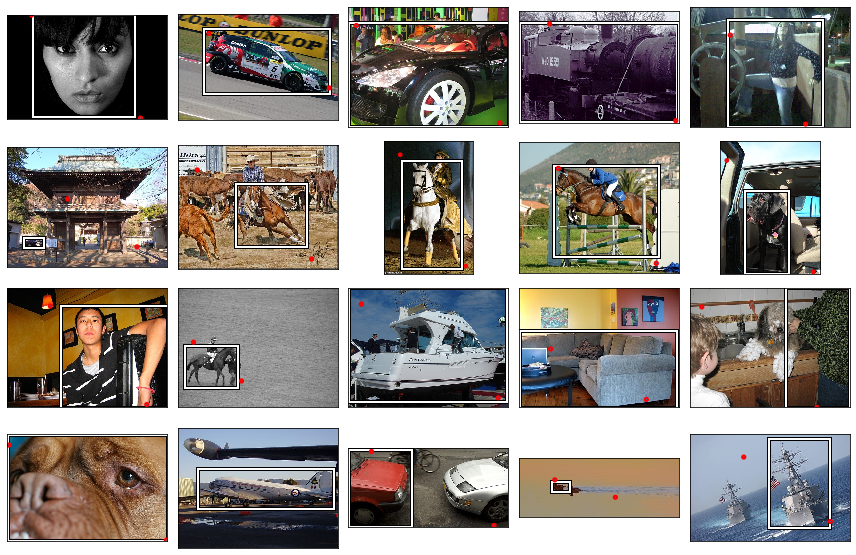

In [302]:
show_imgbbox_list(learn2.data.valid_ds, preds2, vld_szs, 90, 4, 5)

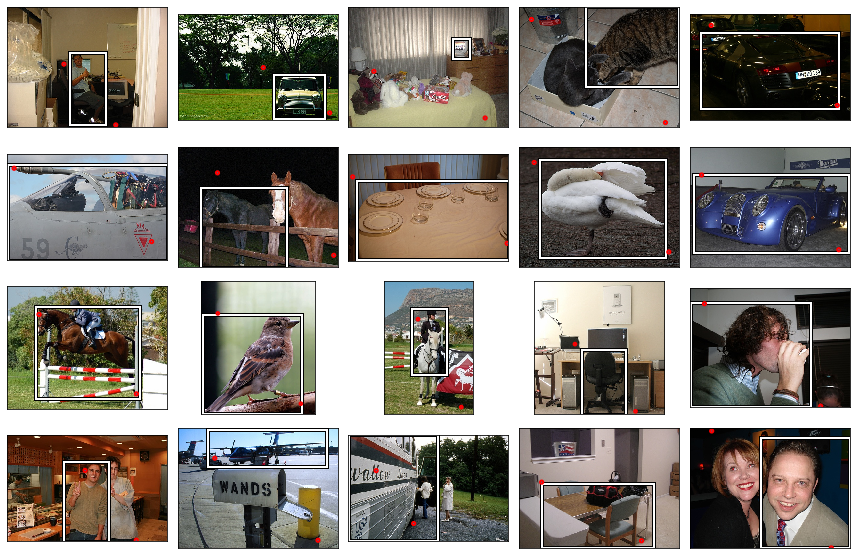

In [299]:
show_imgbbox_list(learn2.data.valid_ds, preds2, vld_szs, 460, 4, 5)

# Step2-2: Largest BBox + Label with custom model and ImageBBox

## build databunch by ImageBBox
Try ImageBBox of single object, we will develop custom model, loss_func, ..

Since we already tried single object classification and its corresponding bbox linear regression separately, it is not hard to combine above two sub-solution into one Model. And fastai's ImageBBox class will make our life easier, too.

Kind of stuck here of writing proper codes for custom_head, it should be simple. Checkout pytorch object detection tutorial here https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

references:
https://medium.com/@btahir/a-quick-guide-to-using-regression-with-image-data-in-fastai-117304c0af90
https://github.com/heye0507/dl_related/blob/master/play_ground/SSD_dev.ipynb

In [74]:
# get largest bounding boxes of total images
def get_bbox_ttl_lrg(bbox_ttl):
    ret = []
    for idx in np.arange(len(bbox_ttl)):
        ret.append(get_largest_annotaion_array(bbox_ttl[idx]))
    return ret

In [75]:
bbox_ttl_lrg = get_bbox_ttl_lrg(bbox_ttl)
bbox_ttl_lrg[:2]

[[[array([ 96., 155., 270., 351.], dtype=float32)], ['car']],
 [[array([ 77.,  89., 336., 403.], dtype=float32)], ['horse']]]

In [76]:
img2bbl_lrg = dict(zip(images_ttl,bbox_ttl_lrg))
get_y_func_bbl = lambda o: img2bbl_lrg[o.name]

In [217]:
bs=12
sz=224

In [218]:
databb = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct(seed=42)
        .label_from_func(get_y_func_bbl)
        .transform(get_transforms(max_rotate=20.,max_zoom=1.2,p_affine=1.,p_lighting=0.5, max_lighting=0.5),
                   size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate)
        .normalize(imagenet_stats)
       )
databb

d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: None

In [219]:
databb.valid_ds.x[0].data.shape

torch.Size([3, 375, 500])

In [220]:
# we can see that ImageBBox is transformed and normalized, nice
databb.train_ds.y[0].data

(tensor([[ 0.4027, -0.3440,  0.9840,  0.0120]]), array([9]))

In [221]:
classes = databb.classes

In [222]:
classes[0]

'background'

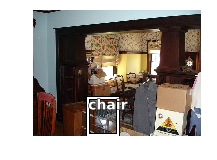

In [184]:
databb.train_ds.x[0].show(y=databb.train_ds.y[0])

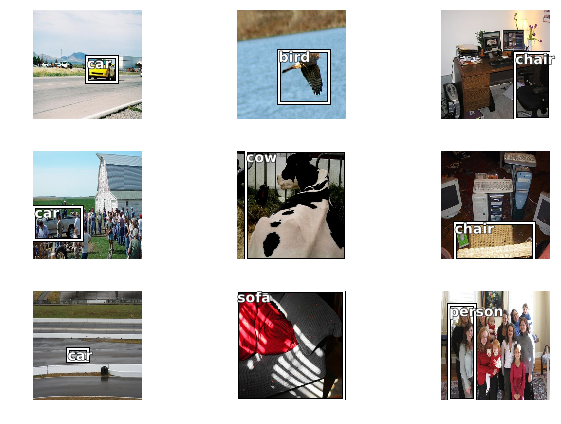

In [185]:
databb.show_batch(3, figsize=(9,6))

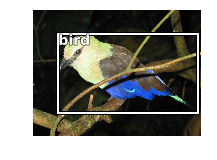

In [186]:
databb.valid_ds.x[0].show(y=databb.valid_ds.y[0])

### Model for single bbox+label and Train

We need to define our loss_func and custom net's head with create_head.

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In total, there shall be 4+20 output features for this single object detection model. Moreover, we have 25 output features since ImageBBox has one special 'background' class.


In [223]:
#arch = models.resnet18
arch = models.resnet34

In [224]:
body = create_body(arch)

More on https://docs.fast.ai/vision.learner.html#create_head

out_features number of resnet18 is 512 * 7 * 7

In [225]:
512*7*7, len(classes)

(25088, 21)

We need a L1Loss + Cross_Entropy loss_func for ImageBBox, L1Loss for bbox linear regression and Cross_Entropy for classification.

reference codes from https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb

def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [226]:
# test run on detn_loss against some data
ytruth = torch.sigmoid(torch.randn((1,25)))
ytarget = databb.valid_ds.y[1]

ytruth, ytarget

(tensor([[0.3789, 0.8506, 0.7748, 0.7562, 0.5338, 0.4583, 0.3627, 0.0930, 0.9387,
          0.4569, 0.3267, 0.5468, 0.5184, 0.2560, 0.4707, 0.2695, 0.7236, 0.5613,
          0.6030, 0.4644, 0.7314, 0.4553, 0.4536, 0.5511, 0.7630]]),
 ImageBBox (323, 500))

In [227]:
bb_i,c_i = ytruth[:, :4], ytruth[:, 4:]
bb_i, c_i

(tensor([[0.3789, 0.8506, 0.7748, 0.7562]]),
 tensor([[0.5338, 0.4583, 0.3627, 0.0930, 0.9387, 0.4569, 0.3267, 0.5468, 0.5184,
          0.2560, 0.4707, 0.2695, 0.7236, 0.5613, 0.6030, 0.4644, 0.7314, 0.4553,
          0.4536, 0.5511, 0.7630]]))

In [228]:
bb_ts, c_ts = ytarget.data
bb_t, c_t = bb_ts, LongTensor(c_ts)
'bbox', bb_t, 'class:', c_t

('bbox', tensor([[ 0.1950, -0.6280,  1.0000,  1.0000]]), 'class:', tensor([7]))

In [229]:
c_t.size(0)

1

In [230]:
F.l1_loss(bb_i, bb_t) 

tensor(0.5329)

In [231]:
c_i[0].reshape(1,len(c_i[0]))

tensor([[0.5338, 0.4583, 0.3627, 0.0930, 0.9387, 0.4569, 0.3267, 0.5468, 0.5184,
         0.2560, 0.4707, 0.2695, 0.7236, 0.5613, 0.6030, 0.4644, 0.7314, 0.4553,
         0.4536, 0.5511, 0.7630]])

In [232]:
F.cross_entropy(c_i, c_t)

tensor(3.0169)

It's always easier to write codes in test-driven way (step by step, line by line), also %debug really helps

In [233]:
ytarget.data

(tensor([[ 0.1950, -0.6280,  1.0000,  1.0000]]), array([7]))

In [328]:
# we shall take 4+21 features array as input and ImageBBox object (4 floats, 1 cat) as target
# The input (predicted output of model.forward): 25 floats
# The target: ImageBBox object 
def imgbb_loss_single(bb_i, c_i, bb_t, c_t):
    c_i1 = c_i.reshape(1,len(c_i))
    c_t1 = c_t.reshape(1)
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i1, c_t1) # simple sumup

# total (bbox, label) loss per batch
def imgbb_loss(input, *targets):
    batch_loss = 0.
    n = 0
    ret = 0.
    
    # loop on one batch and calcu single image loss
    for bbc_i, bb_t,c_t in zip(input,*targets):
        #print(bbc_i, bb_t, c_t)
        bb_i, c_i = bbc_i[:4], bbc_i[4:]
        # no need sigmoid, #bb_i = torch.sigmoid(bb_i)   # *224, target already normalized no need to multiply
        
        single_loss = imgbb_loss_single(bb_i, c_i, bb_t, c_t)
        batch_loss = batch_loss + single_loss
        
        n += 1

    # return all losses of one batch
    ret = batch_loss
    
#    if(n != 0):
#        ret = batch_loss / n
    
    return ret

# average bbox l1loss per batch, for metrics display
def imgbb_l1(input, *targets):
    batch_loss_l1 = 0.
    n = 0
    ret = 0.
    
    for bbc_i, bb_t,_ in zip(input,*targets):
        bb_i = bbc_i[:4]
         # no need sigmoid, #bb_i = torch.sigmoid(bb_i)     # *224, target already normalized no need to multiply
        
        n += 1
        batch_loss_l1 += np.float32(F.l1_loss(bb_i,bb_t))
        
# for single        
#    bb_t,_ = targets
#    bb_i = input[:, :4]
#    bb_i = torch.sigmoid(bb_i)*224
    if(n != 0):
        ret = (batch_loss_l1 / n)

    return tensor(ret)

# average classification loss per batch, for metrics display
def imgc_acc(input, *targets):
    batch_acc_c = 0.
    ret = 0.
    n = 0
    
    # calculate mean accuracy here
    for bbc_i, _, c_t in zip(input,*targets):
        # get lable
        c_i = bbc_i[4:]
        c_i1 = c_i.reshape(1,len(c_i))
        c_t1 = c_t.reshape(1)
        
        n += 1
        batch_acc_c += accuracy(c_i1, c_t1)
    
    if(n != 0): 
        ret = batch_acc_c / n
        
    return ret

##### Got an error ValueError: not enough values to unpack (expected 2, got 1)
use *target will resolve this issue, *target takes target.data outof object, since our target is ImageBBox

In [235]:
imgbb_loss(ytruth, ytarget.data[0], tensor(ytarget.data[1]))

d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


tensor(3.5498)

In [236]:
imgbb_l1(ytruth, ytarget.data[0], tensor(ytarget.data[1]))

tensor(0.5329)

In [237]:
imgc_acc(ytruth, ytarget.data[0], tensor(ytarget.data[1]))

tensor(0.)

In [238]:
headbb = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(classes)),
)

In [239]:
#learn = Learner(data2,arch(),loss_func=nn.L1Loss())
learnbb = cnn_learner(databb, arch, custom_head=headbb, metrics = [imgbb_l1, imgc_acc], loss_func=imgbb_loss)
learnbb.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\Users\Tim\.fastai\data\pascal_2007\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ce

In [240]:
#learnbb.summary()
learnbb.loss_func

<function __main__.imgbb_loss(input, *targets)>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


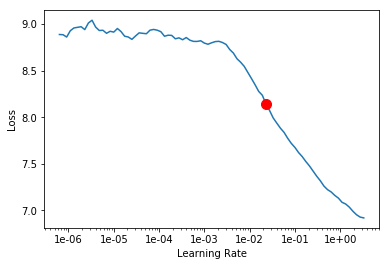

In [100]:
learnbb.lr_find()
learnbb.recorder.plot(suggestion=True)

Got an error: RuntimeError: multi-target not supported at c:\a\w\1\s\windows\pytorch\aten\src\thcunn\generic/ClassNLLCriterion.cu:15

We shall calculate single image loss and sum all single lossses up to one batch loss in imgbb_loss

In [241]:
lr = 2e-2

In [242]:
learnbb.fit_one_cycle(1, lr, wd=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


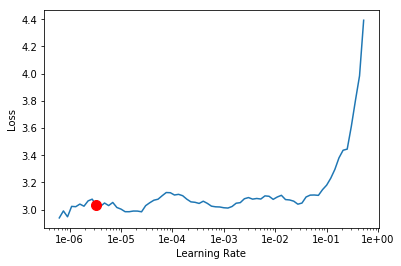

In [147]:
learnbb.lr_find()
learnbb.recorder.plot(suggestion=True)

In [243]:
learnbb.freeze()

In [244]:
learnbb.fit_one_cycle(5, lr/5, wd=0.2)

In [245]:
learnbb.save('step2-2-1')

In [246]:
learnbb.fit_one_cycle(10, lr/10, wd=0.2)

In [247]:
learnbb.save('step2-2-2')

In [1]:
learnbb.load('step2-2-2').to_fp16()

NameError: name 'learnbb' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


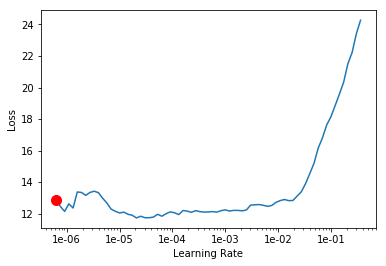

In [248]:
learnbb.lr_find()
learnbb.recorder.plot(suggestion=True)

In [255]:
learnbb.freeze()

In [256]:
learnbb.fit_one_cycle(5, 5e-4, wd=0.2)

In [253]:
learnbb.save('step2-2-3')

In [179]:
gc.collect()

0

In [172]:
%debug

> d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\callback.py(349)on_batch_end()
    347             dist.all_reduce(val, op=dist.ReduceOp.SUM)
    348             val /= self.world
--> 349         self.val += last_target[0].size(0) * val.detach().cpu()
    350 
    351     def on_epoch_end(self, last_metrics, **kwargs):

ipdb> exit


##### Got an error here

d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\callback.py in on_batch_end(self, last_output, last_target, **kwargs)
    347             dist.all_reduce(val, op=dist.ReduceOp.SUM)
    348             val /= self.world
--> 349         self.val += last_target[0].size(0) * val.detach().cpu()
    350 
    351     def on_epoch_end(self, last_metrics, **kwargs):

AttributeError: 'numpy.float64' object has no attribute 'detach'

[detach] detach is in tensor, but not in numpy, wrap imgbb_l1's return value with tensor(..) fix this dump


### Check Predicted ImageBBox

In [257]:
predsbb, _ = learnbb.get_preds(ds_type=DatasetType.Valid)

In [258]:
predsbb[:2]

tensor([[-0.8672, -0.8564,  0.9165,  0.7832, -3.0254, -0.9258,  0.5093,  6.8711,
         -1.9922, -0.6191, -1.4531, -1.7158, -0.4668, -0.8608, -0.3594, -2.1602,
          1.4590, -0.2000, -2.6055,  1.9385,  0.3191,  0.5566, -1.7471, -0.6348,
         -2.1855],
        [-0.1398, -0.6577,  0.8564,  0.6685, -1.9766, -0.5737, -2.2246, -2.2500,
          1.2842, -1.9355,  4.0078,  5.5547, -2.7266, -0.0726, -0.5605, -1.5664,
         -1.6611, -1.5771, -1.5664,  0.5693, -1.5273, -1.0332, -0.2001,  0.9419,
         -1.3936]])

In [259]:
learnbb.data.valid_ds.y.items[:2]

array([[[array([ 70.,  75., 305., 491.], dtype=float32)],
        [3]],

       [[array([193.,  93., 323., 500.], dtype=float32)],
        [7]]], dtype=object)

In [260]:
predsbb[1][:4].reshape(1,4)

tensor([[-0.1398, -0.6577,  0.8564,  0.6685]])

In [261]:
learnbb.data.valid_ds.y[2].data

(tensor([[-0.2492, -0.7040,  0.5015,  0.7440]]), array([1]))

In [266]:
classes

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [1]:
# head2head show image with bbox and class, for ground truth and prediction
# ds: dataset
# preds: predictions
# first: first index of image to show
# num: number of images to show
def show_imgbbc_h2h(ds, preds, first, num=5):
    
    fig,axes = plt.subplots(num,2,figsize=(6,12))
    
    for n in np.arange(num):

        idx = first + n
        ax1 = axes.flat[2*n]
        ax2 = axes.flat[2*n+1]
        
        timg = ds.x[idx]

        # get class name
        pc = [np.argmax(preds[idx][4:]).numpy()]
        predbb = ImageBBox.create(*timg.size, preds[idx][:4].reshape(1,4), pc, classes, scale=False)

        # show ground truth
        timg.show(ax=ax1, y=ds.y[idx], title='Ground Truth')
        # show prediction        
        timg.show(ax=ax2, y=predbb, title='Prediction')

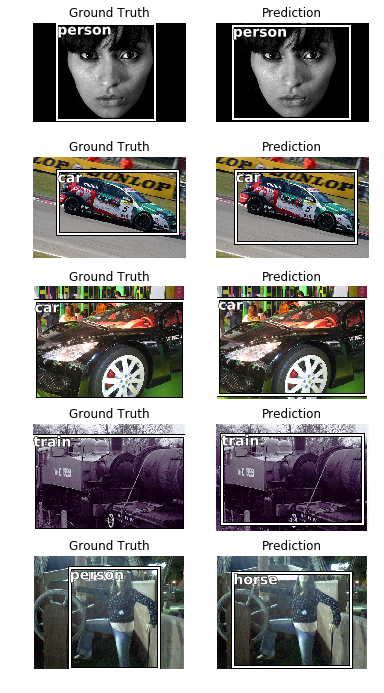

In [323]:
show_imgbbc_h2h(learnbb.data.valid_ds, predsbb, 90)

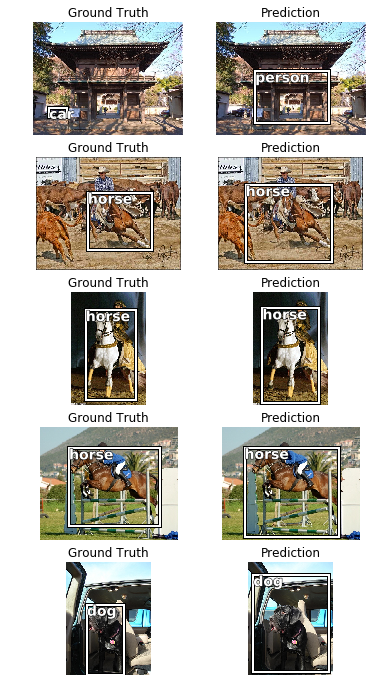

In [325]:
show_imgbbc_h2h(learnbb.data.valid_ds, predsbb, 95)

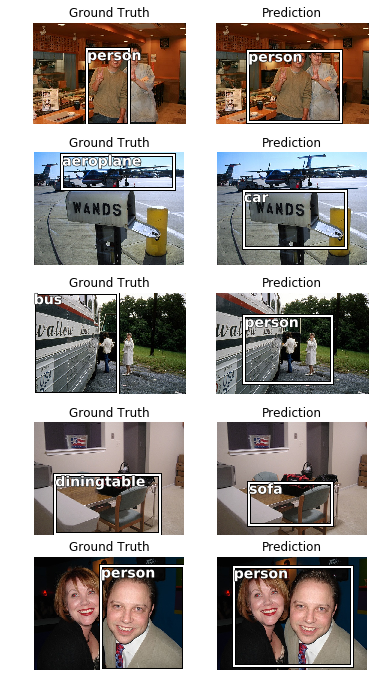

In [326]:
show_imgbbc_h2h(learnbb.data.valid_ds, predsbb, 475)

## Recap: 
About 3 work days to develop&train single object detection 

learned so far:
1. Hands-on customize linear regression for single bbox
2. Customize loss function in batch. When fine-tuning loss_func, I tried [l1loss, (l1loss+cross_entropy), (l1loss * cross_entropy)]. 
3. Customize model and metrics for fastai ImageBBox
4. Many dumps/issues during development, solved them with docs/web

